# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

Загрузим необходимые функции и библиотеки

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

Прочтем данные.

In [30]:
oil_0 = pd.read_csv('/datasets/geo_data_0.csv')
oil_1 = pd.read_csv('/datasets/geo_data_1.csv')
oil_2 = pd.read_csv('/datasets/geo_data_2.csv')
oil_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [31]:
oil_0.info()
print()
oil_1.info()
print()
oil_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3

Проверим на дубликаты.

In [32]:
print(oil_0.duplicated().sum())
print(oil_1.duplicated().sum())
print(oil_2.duplicated().sum())

0
0
0


Итак, product - целевой признак, id на него никак не влиет, для обучения модели он лишний.

In [33]:
oil_0 = oil_0.drop('id', axis=1)
oil_1 = oil_1.drop('id', axis=1)
oil_2 = oil_2.drop('id', axis=1)

# 2. Обучение и проверка модели

Напишем функцию: на вход она принимает датасет, делит выборку на обучающую и валидационную, обучает модель линейной регрессии, печатает среднее по предсказанию и RMSE и возвращает датасет из предсказаний и правильных ответов. (Можно еще отмасштабировать признаки, но в данном случае это лишнее, проверено)

In [34]:
def reserve_rmse(data):
    target = data['product']
    features = data.drop('product', axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
#    numeric = ['f0', 'f1', 'f2']
#    scaler = StandardScaler()
#    scaler.fit(features_train[numeric])
#    features_train[ numeric] = scaler.transform(features_train[numeric])
#    features_valid[numeric] = scaler.transform(features_valid[numeric])
            
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    r2 = r2_score(target_valid, predicted_valid)
        
    print('Ср. предсказанный запас:',predicted_valid.mean())
    print('RMSE:',rmse)
    print('R2:', r2)
    print()
    
    dt = pd.DataFrame()
    dt['target'] = target_valid
    dt['predict'] = predicted_valid

    return dt

In [35]:
table_0 = reserve_rmse(oil_0)
table_1 = reserve_rmse(oil_1)
table_2 = reserve_rmse(oil_2)

Ср. предсказанный запас: 92.59256778438038
RMSE: 37.5794217150813
R2: 0.27994321524487786

Ср. предсказанный запас: 68.728546895446
RMSE: 0.893099286775616
R2: 0.9996233978805127

Ср. предсказанный запас: 94.96504596800489
RMSE: 40.02970873393434
R2: 0.20524758386040443



По второму региону модель предсказывает прекрасно, почти идеально, в первом и третьем регионе - намного хуже. В чем дело?

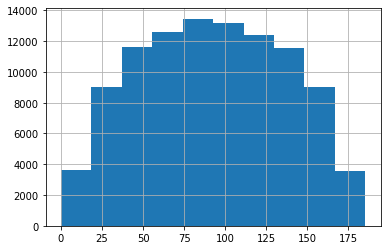

In [36]:
oil_0['product'].hist();

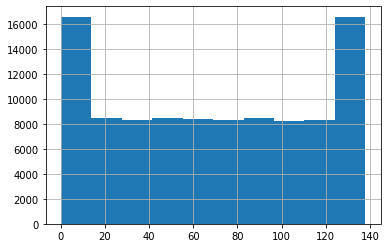

In [37]:
oil_1['product'].hist();

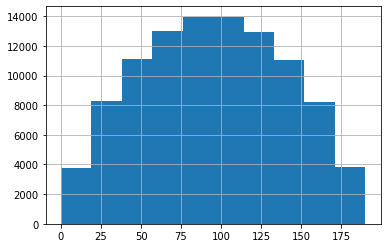

In [38]:
oil_2['product'].hist();

Да, легко предсказывать, когда большинство значений находится примерно на одном уровне (только два выброса по краям). Первый же и третий регионы показывают нормальное распределение.

# 3. Подготовка к расчёту прибыли

Бюджет - 10 млрд.руб.  
Прибыль с единицы - 450 тыс.руб.  
Скважин в регионе - 200 шт.

In [39]:
Budget = 1e10
Yeld = 4.5e5
Quantity = 200
sufficient = Budget / Yeld / Quantity
print(sufficient)


111.11111111111111


Не менее 111 тыс. баррелей должно быть в скважине для безубыточной разработки.   
Средние запасы в скважинах по всем трем регионам (92, 68 и 94 тыс. баррелей) меньше порога безыбыточности при заданном бюджете.

# 4. Расчёт прибыли и рисков 

Напишем функцию, которая подсчитывает прибыль от заданного кол-ва лучших скважин.

In [40]:
def calc_profit(predict,target, count):
    predict_sorted = predict.sort_values(ascending=False)
    sum = target[predict_sorted.index][:count].sum()
    revenue = sum * Yeld
    profit = revenue - Budget
    return profit

Теперь дело за функцией, которая в цикле произвольно выбирает 500 скважин, считает прибыль двухсот лучших и записывает очередное значение в переменную, а затем вычисляет среднее по циклу, а также 2.5% и 97,5% квантиль распределения этой прибыли и риск убытков, как соотношение кол-ва отрицательных значений прибыли к общему кол-ву значений в Bootstrap.

In [41]:
def mean_interval(data):    
    
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        target_subsample = data['target'].sample(n=500, replace=True, random_state=state)
        predict_subsample = data['predict'][target_subsample.index]

        values.append(calc_profit(predict_subsample, target_subsample, Quantity))
        
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    loss_risk = values[values<0].count() / len(values)
                
    print('Средняя прибыль: {0:,}'.format(int(mean)).replace(',', ' '))
    print('2.5%-й квантиль: {0:,}'.format(int(lower)).replace(',', ' '))
    print('97.5%-й квантиль: {0:,}'.format(int(upper)).replace(',', ' '))
    print('Риск убытков:  {:.1%}'.format(loss_risk))
      

In [42]:
print('Первый регион.')
mean_interval(table_0)
print()
print('Второй регион.')
mean_interval(table_1)
print()
print('Третий регион.')
mean_interval(table_2)

Первый регион.
Средняя прибыль: 425 938 526
2.5%-й квантиль: -102 090 094
97.5%-й квантиль: 947 976 353
Риск убытков:  6.0%

Второй регион.
Средняя прибыль: 515 222 773
2.5%-й квантиль: 68 873 225
97.5%-й квантиль: 931 547 591
Риск убытков:  1.0%

Третий регион.
Средняя прибыль: 435 008 362
2.5%-й квантиль: -128 880 547
97.5%-й квантиль: 969 706 954
Риск убытков:  6.4%


Итак, наилучшие показатели у второго региона: здесь наивысшая средняя прибыль, безубыточный доверительный интервал и наименьший риск убытков (1%). Этот регион и будет предложен к разработке.